In [36]:
import os 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import tensorflow as tf
import numpy as np
rng = np.random
from sklearn.linear_model import LinearRegression
from privacy.analysis import privacy_ledger
from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers import dp_optimizer

# Data Loader 


In [37]:
def dataloader(n,p,mu,sigma): 
    X = np.random.choice(3,size = (n,p), p = [0.7,0.25,0.05])
    betha = np.random.normal(mu,sigma,p)
    A = betha.dot(X.T)
    h = np.var(A)
    while h > 1: 
        betha = np.random.normal(mu,sigma,p)
        A = betha.dot(X.T)
        h = np.var(A)
    noise = np.random.normal(0,1-h,n)
    Y = A + noise
    return X, Y 

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(X,Y):
    n_training_samples = X.shape[0]
    n_dim = X.shape[1]
    # We add a line of ones to take into account the intercept
    X = np.reshape(np.c_[np.ones(n_training_samples),X],[n_training_samples,n_dim + 1])
    Y = np.reshape(Y,[n_training_samples,1])
    return X,Y

In [38]:
A,B = dataloader(2000,300,0.01,0.1)
B = np.reshape(B,[A.shape[0],1])
A = normalized_features = feature_normalize(A)
rnd_indices = np.random.rand(len(A)) < 0.80

train_x = A[rnd_indices]
train_y = B[rnd_indices]
test_x = A[~rnd_indices]
test_y = B[~rnd_indices]

m = train_x.shape[0]
n = train_x.shape[1]

m_test = test_x.shape[0]
n_test = test_x.shape[1]

In [39]:
learning_rate = 0.025
training_epochs = 1000
display_step = 250

#Variable 
X = tf.placeholder(tf.float32, [m, n])
Y = tf.placeholder(tf.float32, [m, 1])

X_test = tf.placeholder(tf.float32, [m_test, n])
Y_test = tf.placeholder(tf.float32, [m_test, 1])

# weights
W = tf.Variable(tf.zeros([n, 1], dtype=np.float32), name="weight")
b = tf.Variable(tf.zeros([1], dtype=np.float32), name="bias")

# Construct a linear model
pred = tf.add(tf.matmul(X, W), b)
pred_test = tf.add(tf.matmul(X_test, W), b)
# Mean squared error
cost = tf.reduce_sum(tf.square(pred - Y)) / (2*m) #Loss 
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#R^2
total_error = tf.reduce_sum(tf.square(tf.subtract(Y_test, tf.reduce_mean(Y_test))))
unexplained_error = tf.reduce_sum(tf.square(tf.subtract(Y_test, pred_test)))
R_squared = tf.subtract(tf.cast(1,dtype = 'float32'), tf.math.divide(unexplained_error, total_error))

#Differential Privacy
learning_rate=0.25
noise_multiplier=1.6
l2_norm_clip=1.5

#Variable/DP
X_DP = tf.placeholder(tf.float32, [m_test//4, n])
Y_DP = tf.placeholder(tf.float32, [m_test//4, 1])
#Linear Model
pred_DP = tf.add(tf.matmul(X_DP, W), b)
#MSE
cost_DP = tf.reduce_sum(tf.square(pred_DP - Y_DP)) / (2*m) #Loss 

optimizer_DP = dp_optimizer.DPGradientDescentGaussianOptimizer(
    l2_norm_clip=0.4,
    noise_multiplier=0.5,
    num_microbatches=1,
    learning_rate=0.025
    )
train_op = optimizer_DP.minimize(loss=cost)

Epoch: 0250 cost= 0.110990115
Epoch: 0500 cost= 0.082842089
Epoch: 0750 cost= 0.082263112
Epoch: 1000 cost= 0.088738173
DP Optimization Finished!
Training cost= 0.08873817 W= [-5.22984974e-02 -3.40875164e-02  2.04924718e-02  3.91630232e-02
  3.16599458e-02  4.15875614e-02 -1.72389031e-03 -7.34949112e-03
  4.05928791e-02  5.72160408e-02 -9.17074829e-02 -3.87678156e-04
  2.62727439e-02 -2.80589275e-02  1.30098164e-01 -6.27495497e-02
  5.34659363e-02 -2.16523856e-02 -1.29385768e-02  1.52783588e-01
  2.55793892e-02 -5.86486124e-02  3.08096930e-02  5.12072705e-02
  3.85867208e-02  1.03053981e-02  1.58907715e-02  6.83252215e-02
 -3.03333458e-02 -8.28493759e-03  5.40288836e-02 -1.08880484e-02
 -9.63923112e-02 -7.03509971e-02  3.37996036e-02  3.89985368e-02
 -6.26416802e-02  5.73067255e-02 -1.94517113e-02  3.93191129e-02
  1.82535592e-02  8.52661133e-02  3.46652716e-02  1.44810632e-01
 -5.86495399e-02 -3.76724303e-02  6.16053678e-03  6.97975680e-02
  1.04119524e-01 -4.92056459e-02  1.56478673e

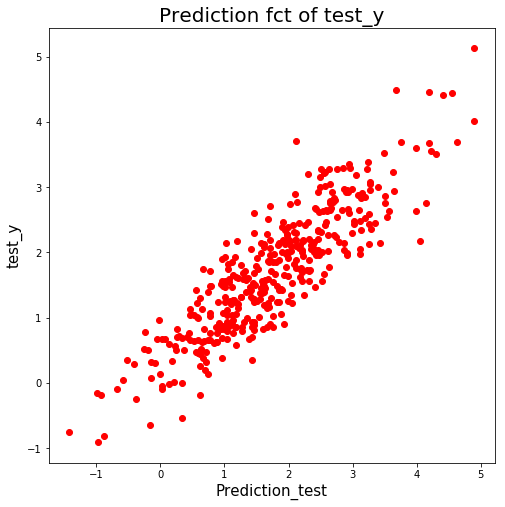

In [40]:
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))

with tf.Session() as sess:
        #initialization of the variables
        init = tf.global_variables_initializer()
        sess.run(init)

        for epoch in range(training_epochs):
            sess.run(train_op, feed_dict={X: train_x, Y: train_y})
            
            if (epoch+1) % display_step == 0:
                c = sess.run(cost, feed_dict={X: train_x, Y: train_y})
                print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        print ("DP Optimization Finished!")    
        training_cost = sess.run(cost, feed_dict={X: train_x, Y: train_y})
        
        Variance = sess.run(total_error,feed_dict={Y_test: test_y})
        SSE = sess.run(unexplained_error, feed_dict={X_test: test_x, Y_test: test_y} )
        R_2 = sess.run(R_squared,feed_dict={X_test: test_x, Y_test: test_y})
        Prediction = sess.run(pred_test,feed_dict={X_test: test_x})
        print ("Training cost=", training_cost, "W=", sess.run(W).ravel(), "b=", sess.run(b), '\n',\
              "Variance_test=",Variance, "SSE= ",SSE,"R_2_Train= ", R_2)

        rdp = compute_rdp(q=1,
                  noise_multiplier=0.5,
                  steps= training_epochs,
                  orders=orders)
        epsilon = get_privacy_spent(orders, rdp, target_delta=1e-4)[0]
        print("privacy spent ", epsilon)
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Prediction_test', fontsize = 15)
        ax.set_ylabel('test_y', fontsize = 15)
        ax.set_title('Prediction fct of test_y', fontsize = 20)
        ax.scatter(Prediction,test_y,c = 'r')
        
#280.42670185988084

Epoch: 0250 cost= 0.006452615
Epoch: 0500 cost= 0.006206142
Epoch: 0750 cost= 0.006204575
Epoch: 1000 cost= 0.006204558
DP Optimization Finished!
Training cost= 0.0062045576 W= [-9.09774601e-02 -2.49930974e-02  3.01928185e-02  5.58624491e-02
  6.34348243e-02  4.96123917e-02  2.16685887e-02  5.98979602e-03
  3.29795144e-02  8.73876140e-02 -6.90849274e-02 -2.49974877e-02
  4.72761132e-02 -3.98099571e-02  7.91901201e-02 -3.45532559e-02
  1.43420650e-02 -6.64713904e-02  4.81367409e-02  1.16684780e-01
  2.64830887e-02 -6.72922283e-02  2.00004280e-02  1.96420830e-02
  5.80818839e-02  2.67936066e-02  1.50629664e-02  4.58809547e-02
 -6.05006889e-02 -4.42167837e-03  5.13768457e-02  2.75488254e-02
 -9.20594633e-02 -2.58652903e-02  2.52827443e-03  2.94593219e-02
 -5.17611839e-02  4.23216522e-02 -2.51209848e-02  1.04333088e-02
  1.58550888e-02  4.72831689e-02 -4.85641696e-03  1.17920183e-01
 -7.99831375e-02 -2.06849836e-02 -6.09789463e-03  9.78714302e-02
  9.10444707e-02 -3.25595289e-02  1.9683259

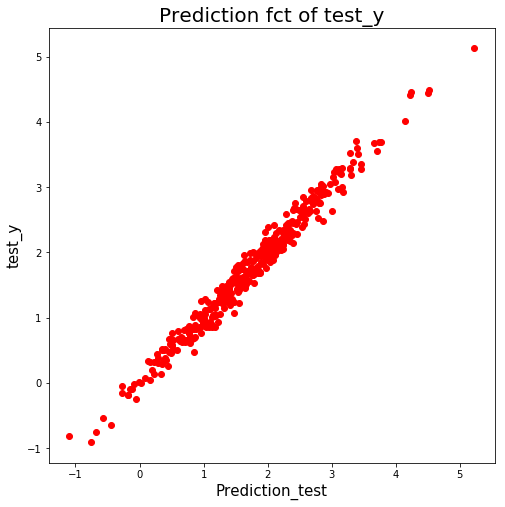

In [41]:
with tf.Session() as sess:
        #initialization of the variables
        init = tf.global_variables_initializer()
        sess.run(init)

        for epoch in range(training_epochs):
            sess.run(optimizer, feed_dict={X: train_x, Y: train_y})
            
            if (epoch+1) % display_step == 0:
                c = sess.run(cost, feed_dict={X: train_x, Y:train_y})
                print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        
        print ("DP Optimization Finished!")    
        training_cost = sess.run(cost, feed_dict={X: train_x, Y: train_y})
        Variance = sess.run(total_error,feed_dict={Y_test: test_y})
        SSE = sess.run(unexplained_error, feed_dict={X_test: test_x, Y_test: test_y} )
        R_2 = sess.run(R_squared,feed_dict={X_test: test_x, Y_test: test_y})
        Prediction = sess.run(pred_test,feed_dict={X_test: test_x})
        print ("Training cost=", training_cost, "W=", sess.run(W).ravel(), "b=", sess.run(b), '\n',\
              "Variance_test=",Variance, "SSE= ",SSE,"R_2_Train= ", R_2)
        
        
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Prediction_test', fontsize = 15)
        ax.set_ylabel('test_y', fontsize = 15)
        ax.set_title('Prediction fct of test_y', fontsize = 20)
        ax.scatter(Prediction,test_y,c = 'r')

In [42]:
#Think about adjusted R^2

In [43]:
linearRegressor = LinearRegression()
linearRegressor.fit(train_x,train_y)
linearRegressor.score(test_x,test_y)

0.9781952197118734

In [17]:
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))